# Graph
[Draw] graphs using the [ForceAtlas2] energy model. Graphs can be [directed] and/or [weighted].

GraphFrame comes with a slightly modified [Krackhardt kite] as an example.

For a larger example, see the [7 Degrees of Martin Brundle].


[Draw]: https://en.wikipedia.org/wiki/Graph_drawing
[ForceAtlas2]: https://doi.org/10.1371/journal.pone.0098679
[directed]: https://en.wikipedia.org/wiki/Directed_graph
[weighted]: https://en.wikipedia.org/wiki/Glossary_of_graph_theory#weighted_graph
[Krackhardt kite]: https://en.wikipedia.org/wiki/Krackhardt_kite_graph
[7 Degrees of Martin Brundle]: https://brundling.neocities.org/

In [1]:
from graph import GraphFrame

## draw an example graph

<Axes: xlabel='x', ylabel='y'>

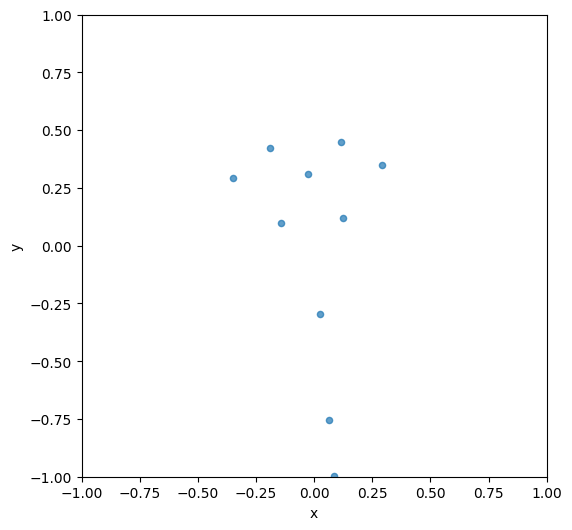

In [2]:
kite = GraphFrame.example()
kite.plot()

## draw again
Starting points are random, so the new plot may be different.

<Axes: xlabel='x', ylabel='y'>

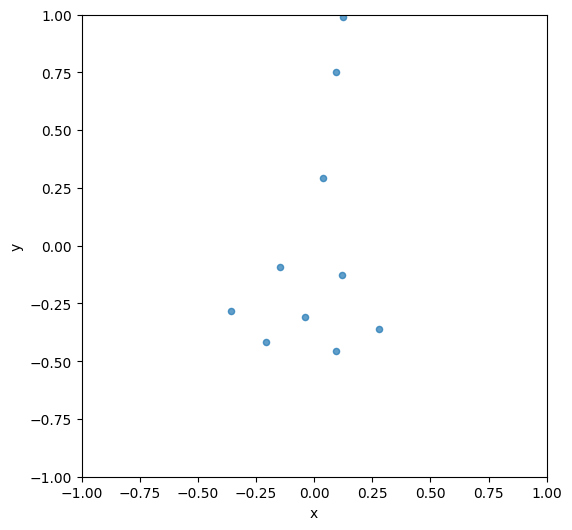

In [3]:
kite.plot()

## customize colors and sizes

<Axes: xlabel='x', ylabel='y'>

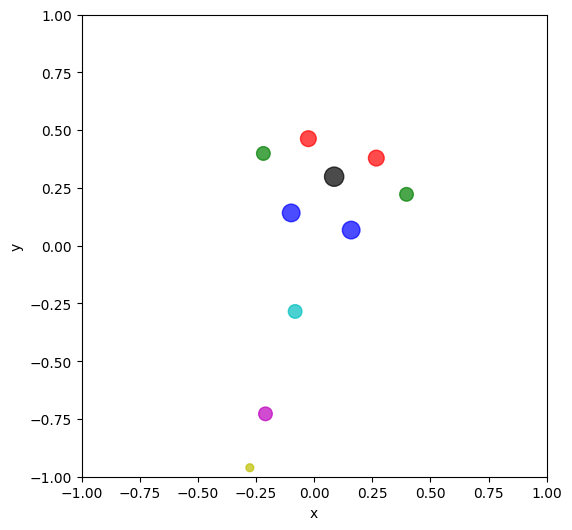

In [4]:
color = list('rrgkgbbcmy')
size = 32 * kite.degin
kite.plot(c=color, s=size)

## calculate node positions without drawing

In [5]:
# Call with a number of timesteps (or use the default)
kite(64)

,x,y
a,-0.436035,0.199420
b,-0.433087,-0.105094
c,-0.324027,0.369545
d,-0.307265,0.049235
e,-0.317888,-0.273097
f,-0.104708,0.173682
g,-0.105934,-0.095241
h,0.297436,-0.014811
i,0.749209,-0.116319
j,0.982299,-0.187321


## build a graph
GraphFrame can import and export several graph data structures.

Internally, each graph is stored as a DataFrame with 3 columns: `source`, `target`, `weight`. Each row represents one link. For example, the row `('a', 'b', 1)` means node `a` points to node `b` with weight 1.

If no weights are provided, then links are weighted by how often they appear.

[directed graph]: https://en.wikipedia.org/wiki/Directed_graph

In [6]:
# from (source, target, weight) triples
triples = (
    ('alice', 'bob', 2),
    ('alice', 'carol', 1),
    ('bob', 'alice', 1),
    ('bob', 'carol', 1),
    ('carol', 'alice', 1),
)
abc = GraphFrame(triples)
abc.links

,source,target,weight
0,alice,bob,2
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1


In [7]:
# from (source, target) pairs
pairs = (
    ('alice', 'bob'),
    ('alice', 'bob'),
    ('alice', 'carol'),
    ('bob', 'alice'),
    ('bob', 'carol'),
    ('carol', 'alice'),
)
GraphFrame(pairs).links

,source,target,weight
0,alice,bob,2
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1


In [8]:
# from a {node: [list of source nodes]} mapping
sources = {
    'alice': ['bob', 'carol'],
    'bob': ['alice', 'alice'],
    'carol': ['alice','bob'],
}
GraphFrame.from_sources(sources).links

,source,target,weight
0,alice,bob,2
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1


In [9]:
# from a {node: [list of target nodes]} mapping
targets = {
    'alice': ['bob', 'bob', 'carol'],
    'bob': ['alice', 'carol'],
    'carol': ['alice'],
}
GraphFrame.from_targets(targets).links

,source,target,weight
0,alice,bob,2
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1


## graph attributes

In [10]:
# Series of indegrees (total weight of links to each node)
abc.degin

target
alice    2
bob      2
carol    2
Name: weight, dtype: int64

In [11]:
# Series of outdegrees (total weight of links from each node)
abc.degout

source
alice    3
bob      2
carol    1
Name: weight, dtype: int64

In [12]:
# transpose (all links reversed)
abc.flipped.links

,source,target,weight
0,alice,bob,1
1,alice,carol,1
2,bob,alice,2
3,carol,alice,1
4,carol,bob,1


In [13]:
# SciPy sparse adjacency matrix
abc.matrix

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [14]:
# NumPy adjacency matrix
abc.matrix.toarray()

array([[0, 2, 1],
       [1, 0, 1],
       [1, 0, 0]])

In [15]:
# list of distinct nodes
abc.nodes

['alice', 'bob', 'carol']

In [16]:
# Series of weights for each distinct (source, target)
abc.weights

source  target
alice   bob       2
        carol     1
bob     alice     1
        carol     1
carol   alice     1
Name: weight, dtype: int64

## graph iterators

In [17]:
# iterate over links (as namedtuples)
for link in abc:
    print(link)

Link(source='alice', target='bob', weight=2)
Link(source='alice', target='carol', weight=1)
Link(source='bob', target='alice', weight=1)
Link(source='bob', target='carol', weight=1)
Link(source='carol', target='alice', weight=1)


In [18]:
# iterate over links (as components)
for source, target, weight in abc:
    print(f"{source} -> {target}: {weight}")

alice -> bob: 2
alice -> carol: 1
bob -> alice: 1
bob -> carol: 1
carol -> alice: 1


In [19]:
# iterate over links without weights
for s,t in abc.pairs():
    print(f"{s} -> {t}")

alice -> bob
alice -> carol
bob -> alice
bob -> carol
carol -> alice


In [20]:
# iterate over (node, list of sources) pairs
for node, sources in abc.sources():
    print(f"{node} <- {sources}")

alice <- ['bob', 'carol']
bob <- ['alice']
carol <- ['alice', 'bob']


In [21]:
# iterate over (node, list of sources) pairs
for node, targets in abc.targets():
    print(f"{node} -> {targets}")

alice -> ['bob', 'carol']
bob -> ['alice', 'carol']
carol -> ['alice']


## export a graph

In [22]:
# as a DataFrame
abc.links.copy()

,source,target,weight
0,alice,bob,2
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1


In [23]:
# as a string
print(str(abc))

alice -> bob: 2
alice -> carol: 1
bob -> alice: 1
bob -> carol: 1
carol -> alice: 1


In [24]:
# as a list of namedtuples
list(abc)

[Link(source='alice', target='bob', weight=2),
 Link(source='alice', target='carol', weight=1),
 Link(source='bob', target='alice', weight=1),
 Link(source='bob', target='carol', weight=1),
 Link(source='carol', target='alice', weight=1)]

In [25]:
# as a list of pairs
list(abc.pairs())

[('alice', 'bob'),
 ('alice', 'carol'),
 ('bob', 'alice'),
 ('bob', 'carol'),
 ('carol', 'alice')]

In [26]:
# as a {node: sources} dictionary (Caution: discards weights!)
dict(abc.sources())

{'alice': ['bob', 'carol'], 'bob': ['alice'], 'carol': ['alice', 'bob']}

In [27]:
# as a {node: targets} dictionary (Caution: discards weights!)
dict(abc.targets())

{'alice': ['bob', 'carol'], 'bob': ['alice', 'carol'], 'carol': ['alice']}

## help

In [28]:
help(GraphFrame)

Help on class GraphFrame in module graph:

class GraphFrame(builtins.object)
 |  GraphFrame(links)
 |  
 |  Draw force-directed graphs with the Gephi ForceAtlas2 energy model.
 |  Graphs can be directed and/or weighted with integers or floats.
 |  If no weights are given, then links are weighted by how often they appear.
 |  Links with weight zero will be dropped.
 |  
 |  Inputs:
 |      DataFrame with [source, target, weight] as first 3 columns, OR
 |      DataFrame with [source, target] as first 2 columns, OR
 |      anything that pandas.DataFrame() can convert to one of the above
 |  
 |  Methods defined here:
 |  
 |  __call__(self, nsteps=128)
 |      DataFrame: Calculate ['x', 'y'] coordinates for each node.
 |      Nodes are recentered and scaled to fit in the unit circle.
 |      Initial positions are random in the unit square.
 |  
 |  __init__(self, links)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |      Iterable of named